In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics
from scipy import stats

## Analysis for GM12878

In [143]:
# Directory containing the data files
directory = './GM12878'

In [144]:
# helper to load a single file into a contact matrix
def load_contact_matrix(filepath):
    data = pd.read_csv(filepath, sep='\t', header=None)
    data.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
    data = data[data['chr1'] == data['chr2']]
    max_pos = max(data['pos1'].max(), data['pos2'].max())
    min_pos = min(data['pos1'].min(), data['pos2'].min())
    bins = np.linspace(min_pos, max_pos, num=201)
    data['pos1_bin'] = pd.cut(data['pos1'], bins, labels=False, include_lowest=True)
    data['pos2_bin'] = pd.cut(data['pos2'], bins, labels=False, include_lowest=True)
    pivot_table = data.groupby(['pos1_bin', 'pos2_bin'])['interaction'].sum().unstack(fill_value=0)
    return pivot_table.to_numpy()

# Function to normalize a contact matrix
def z_score_normalize(matrix):
    mean_val = np.mean(matrix)
    std_val = np.std(matrix)
    normalized_matrix = (matrix - mean_val) / std_val
    return normalized_matrix

# Function to load all the matrices in a directory
def load_matrices(directory, contact_matrices, filepaths):
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            normalized_matrix = z_score_normalize(load_contact_matrix(filepath))
            contact_matrices.append(normalized_matrix)
            filepaths.append(filepath)
            
# Function to extend matrix to the target dimension
def extend_matrix(matrix, target_dim):
    extended_matrix = np.zeros(target_dim)
    rows, cols = matrix.shape
    extended_matrix[:rows, :cols] = matrix
    return extended_matrix

# Function to calculate the Frobenius norm between two matrices
def frobenius_norm(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2, 'fro')

def plot_matrices(num_matrices, matrices_per_figure, contact_matrices):
    for start in range(0, num_matrices, matrices_per_figure):
        end = min(start + matrices_per_figure, num_matrices)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if start + i < end:
            matrix = contact_matrices[start + i]
            im = ax.imshow(matrix, cmap='coolwarm', interpolation='none')
            ax.set_title(f'Matrix {start + i + 1}')
            ax.set_xlabel('Position along Chromosome')
            ax.set_ylabel('Position along Chromosome')
            fig.colorbar(im, ax=ax, label='Interaction Frequency')
        else:
            fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()
    

def plot_distance_matrix(num_matrices, contact_matrices):
    # Initialize the distance matrix
    distance_matrix = np.zeros((num_matrices, num_matrices))

    # Compute the distances and store in the distance matrix
    for i in range(num_matrices):
        for j in range(i, num_matrices):
            distance = frobenius_norm(contact_matrices[i], contact_matrices[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    return distance_matrix

def find_average(contact_matrices):
    average_list = []
    for matrix in contact_matrices:
        sum = 0
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                sum += matrix[i][j]
        avg = sum / (matrix.shape[0] * matrix.shape[1])
        average_list.append(avg)
    return average_list

def find_average_instance(matrix):
    sum = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            sum += matrix[i][j]
    return sum / (matrix.shape[0] * matrix.shape[1])

def matrix_avg_stats(average_list):
    avg = statistics.mean(average_list)
    sd = statistics.stdev(average_list)
    minimum = min(average_list)
    maximum = max(average_list)
    return {"average": avg, "standard deviation": sd, "minimum": minimum, "maximum": maximum}

In [145]:
# Load all contact matrices into a list
contact_matrices_GM12878 = []
filepaths_GM12878 = []

In [146]:
load_matrices(directory, contact_matrices_GM12878, filepaths_GM12878)


num_matrices = len(contact_matrices_GM12878)

# Target dimension
target_dim = (200, 200)

# Extend all matrices
contact_matrices_GM12878 = [extend_matrix(matrix, target_dim) for matrix in contact_matrices_GM12878]

In [147]:
# Calculate the Frobenius norm (distance) between the matrices
# distance = frobenius_norm(contact_matrices_GM12878[3], contact_matrices_GM12878[0])
# Print the distance
# print("Frobenius Norm (Distance) between the matrices:", distance)

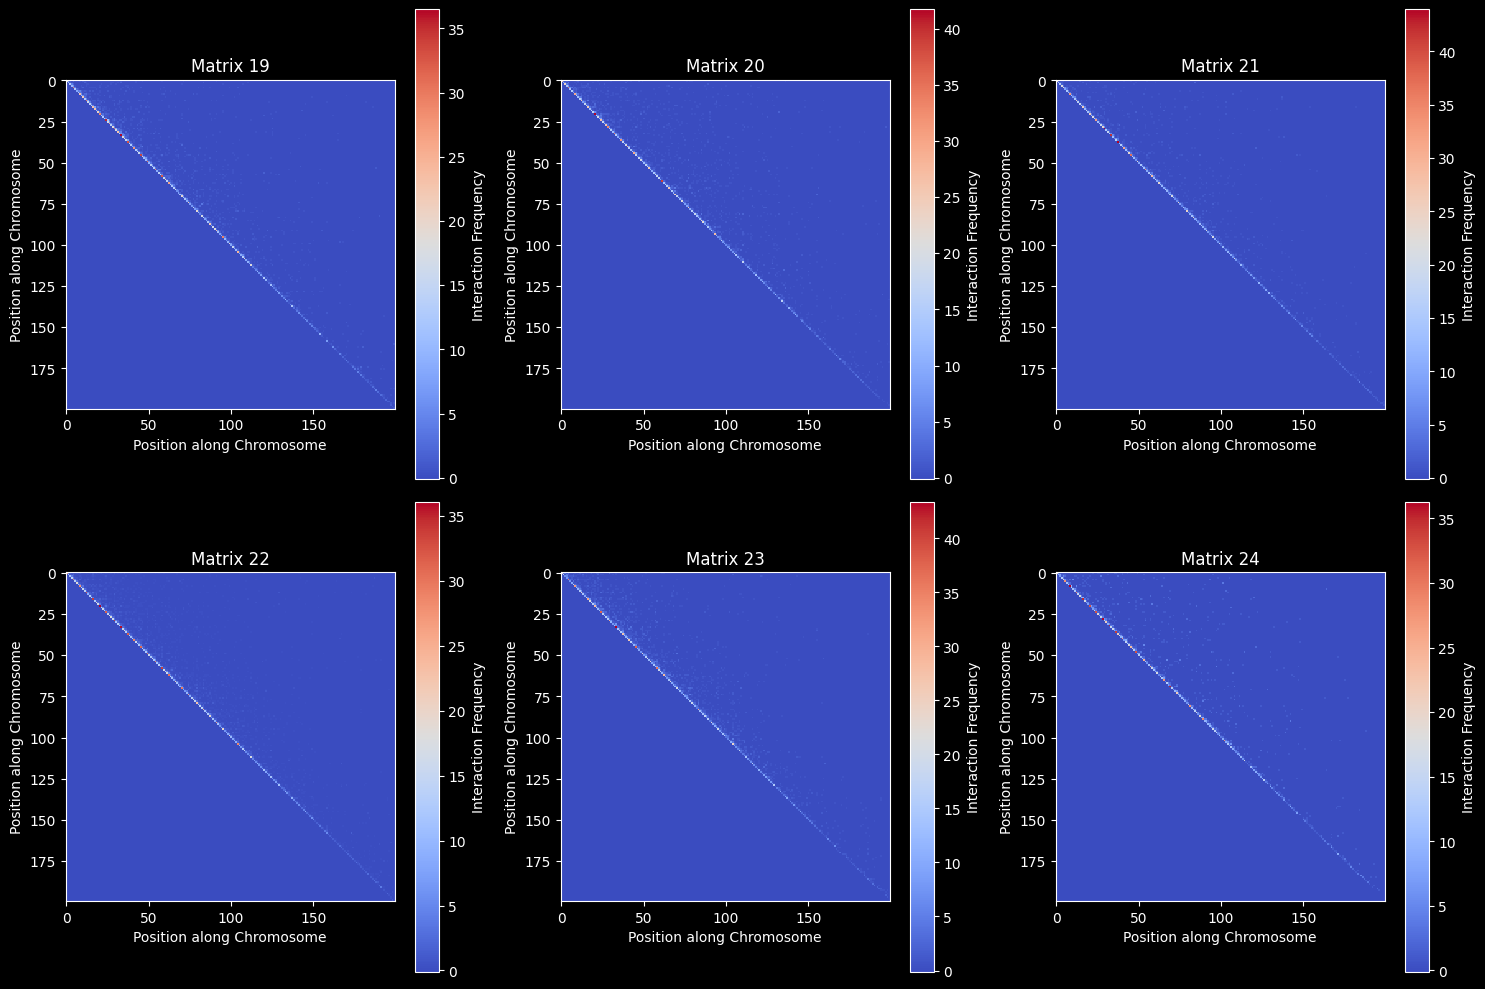

In [148]:
# Plot the matrices in batches of 6 per figure
num_matrices = len(contact_matrices_GM12878)
matrices_per_figure = 6

plot_matrices(num_matrices, matrices_per_figure, contact_matrices_GM12878)

In [149]:
distance_matrix_GM12878 = plot_distance_matrix(num_matrices, contact_matrices_GM12878)

In [150]:
average_GM12878 = find_average(contact_matrices_GM12878)

average_stats_GM12878 = matrix_avg_stats(average_GM12878)

## Analysis for HAP1

In [151]:
directory = './HAP1'

# Load all contact matrices into a list
contact_matrices_HAP1 = []
filepaths_HAP1 = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_HAP1, filepaths_HAP1)


num_matrices = len(contact_matrices_HAP1)

# Target dimension
target_dim = (200, 200)

# Extend all matrices
contact_matrices_HAP1 = [extend_matrix(matrix, target_dim) for matrix in contact_matrices_HAP1]

distance_matrix_HAP1 = plot_distance_matrix(num_matrices, contact_matrices_HAP1)

average_HAP1 = find_average(contact_matrices_HAP1)

average_stats_HAP1 = matrix_avg_stats(average_HAP1)

## Analysis for Hela

In [152]:
directory = './Hela'

# Load all contact matrices into a list
contact_matrices_Hela = []
filepaths_Hela = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_Hela, filepaths_Hela)


num_matrices = len(contact_matrices_Hela)

# Target dimension
target_dim = (200, 200)

# Extend all matrices
contact_matrices_Hela = [extend_matrix(matrix, target_dim) for matrix in contact_matrices_Hela]

distance_matrix_Hela = plot_distance_matrix(num_matrices, contact_matrices_Hela)

average_Hela = find_average(contact_matrices_Hela)

average_stats_Hela = matrix_avg_stats(average_Hela)

In [153]:
directory = './K562'

# Load all contact matrices into a list
contact_matrices_K562 = []
filepaths_K562 = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_K562, filepaths_K562)


num_matrices = len(contact_matrices_K562)

# Target dimension
target_dim = (200, 200)

# Extend all matrices
contact_matrices_K562 = [extend_matrix(matrix, target_dim) for matrix in contact_matrices_K562]

distance_matrix_K562 = plot_distance_matrix(num_matrices, contact_matrices_K562)

average_K562 = find_average(contact_matrices_K562)

average_stats_K562 = matrix_avg_stats(average_K562)

In [190]:
# Hypothesis testing:
# Null hypothesis: The given average belongs to the distribution.
avg_to_test = find_average_instance(contact_matrices_GM12878[9])

t_statistic, p_value = stats.ttest_1samp(average_HAP1, avg_to_test)

# Print the test statistic and p-value
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.0001

# Conclusion
if p_value < alpha:
    print("Reject the null hypothesis: The given average does not belong to the distribution.")
else:
    print("Fail to reject the null hypothesis: The given average belongs to the distribution.")

T-statistic: 7.042825230456116
P-value: 3.697318329213776e-12
Reject the null hypothesis: The given average does not belong to the distribution.
